In [53]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import sqrt
from math import sin, cos, atan2, radians
from sklearn.preprocessing import StandardScaler

import sklearn

In [54]:
address = pd.read_csv('data_2/address_2.csv', low_memory=False)
company = pd.read_csv('data_2/company_2.csv', low_memory=False)
contract_person = pd.read_csv('data_2/contact_person_2.csv', low_memory=False)
contract_authority = pd.read_csv('data_2/contracting_authority_2.csv', low_memory=False)
offer = pd.read_csv('data_2/offer_2.csv', low_memory=False)
procurement = pd.read_csv('data_2/procurement_2.csv', low_memory=False)

In [55]:
procurement["bids_submission_deadline"] = pd.to_datetime(procurement["bids_submission_deadline"], format='%Y-%m-%d', errors = 'coerce')
procurement["date_of_contract_close"] = pd.to_datetime(procurement["date_of_contract_close"], format='%Y-%m-%d', errors = 'coerce')
procurement["date_of_publication"] = pd.to_datetime(procurement["date_of_publication"], format='%Y-%m-%d', errors = 'coerce')
procurement['publication_close_interval'] = (procurement['date_of_contract_close'] - procurement['date_of_publication']).dt.days
procurement['bids_close_interval'] = (procurement['bids_submission_deadline'] - procurement['date_of_publication']).dt.days

In [56]:
num_of_offers = (offer['procurement_id'].value_counts()).to_frame()
num_of_offers.rename(columns={"count": "number_of_offers"}, inplace=True)

In [57]:
offer_with_counts = pd.merge(offer, num_of_offers, on='procurement_id', how='outer')
df_anomaly = pd.merge(offer_with_counts, procurement, left_on='procurement_id', right_on='id', how='left')
df_anomaly['is_winner'] = (df_anomaly['company_id'] == df_anomaly['supplier_id'])
df_anomaly.drop(columns=['id_y', 'procurement_id'], inplace=True)
df_anomaly = pd.merge(df_anomaly, company, left_on='company_id', right_on='id', how='left')
df_anomaly.drop(columns=['id'], inplace=True)
df_anomaly.drop(columns=['supplier_id', 'id_x', 'procurement_name', 'name_from_nipez_codelist', 'system_number', 'vat_id_number', 'company_name'], inplace=True)
df_anomaly = pd.merge(df_anomaly, contract_authority, left_on='contracting_authority_id', right_on='id', how='left')

In [58]:
total_wins = df_anomaly.groupby('company_id')['is_winner'].sum().to_frame()
total_wins.rename(columns={'is_winner' : 'total_wins'}, inplace=True)
total_offers = (df_anomaly['company_id'].value_counts()).to_frame()
total_offers.rename(columns={'count' : 'total_offers'}, inplace=True)
total_procurements = (df_anomaly['contracting_authority_id'].value_counts()).to_frame()
total_procurements.rename(columns={'count' : 'total_procurements'}, inplace=True)

In [59]:
df_anomaly = pd.merge(df_anomaly, total_wins, on='company_id', how='left')
df_anomaly = pd.merge(df_anomaly, total_offers, on='company_id', how='left')
df_anomaly = pd.merge(df_anomaly, total_procurements, on='contracting_authority_id', how='left')

In [60]:
def get_distance(id_company, id_contracter):
    company_address = address.loc[address['id'] == id_company]
    contracter_address = address.loc[address['id'] == id_contracter]
    try:
        lat1 = radians(company_address.latitude.iloc[0])
        lat2 = radians(contracter_address.latitude.iloc[0])
        lon1 = radians(company_address.longitude.iloc[0])
        lon2 = radians(contracter_address.longitude.iloc[0])
        R = 6371
        diff_lat = abs(lat1 - lat2)
        diff_log = abs(lon1 - lon2)
        a = sin(diff_lat/2)**2 + cos(lat1) * cos(lat2) * sin(diff_log/2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        return R * c
    except:
        return np.NAN

In [61]:
df_anomaly.loc[:,'distance'] = df_anomaly.apply(lambda x: get_distance(x['address_id_x'], x['address_id_y']), axis =1)

In [62]:
names_to_drop = ['company_id', 'contact_person_id', 'organisation_id', 'contracting_authority_id', 'code_from_nipez_codelist', 'date_of_contract_close', 'date_of_publication', 'bids_submission_deadline', 'address_id_y', 'address_id_x', 'url', 'contracting_authority_name', 'id']

df_anomaly.drop(columns=names_to_drop, inplace=True)

In [63]:
df_anomaly['num_of_nan'] = df_anomaly.isna().sum(axis=1)

In [64]:
df_anomaly['place_of_performance'].replace({'Hlavní město Praha': 'Praha', 'EXTRA-REGIO' : 'Extra-Regio', np.nan : 'Unknown'}, inplace=True)
df_anomaly['public_contract_regime'].replace({np.nan : 'Unknown'}, inplace=True)
df_anomaly['type'].replace({np.nan : 'Unknown'}, inplace=True)
df_anomaly['type_of_procedure'].replace({np.nan : 'Unknown'}, inplace=True)
df_anomaly['total_wins'] = df_anomaly['total_wins'].astype("int")



In [65]:
df_anomaly.shape

(70338, 23)

In [66]:
df_anomaly.dropna(inplace=True)

In [67]:
df_anomaly.shape

(19289, 23)

In [68]:
df_anomaly_one_hot = pd.get_dummies(df_anomaly, columns=['place_of_performance', 'public_contract_regime', 'type', 'type_of_procedure'])

In [69]:
df_anomaly_one_hot_scaled = StandardScaler().fit_transform(df_anomaly_one_hot) 

In [70]:
import umap.umap_ as umap

In [71]:
reducer = umap.UMAP()

In [72]:
embedding = reducer.fit_transform(df_anomaly_one_hot)

C:\Users\marti\PycharmProjects\bakalarka\venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [73]:
import umap.plot
import umap.utils

In [95]:
umap_model = umap.UMAP(
    n_neighbors=30,
    min_dist=0.0,
    n_components=3).fit(df_anomaly_one_hot_scaled)
umap_transformed = umap_model.transform(df_anomaly_one_hot_scaled)

C:\Users\marti\PycharmProjects\bakalarka\venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [96]:
pca_transformed = PCA(n_components='mle', svd_solver='full').fit_transform(df_anomaly_one_hot_scaled)
pca_transformed.shape

(19289, 63)

In [97]:
from sklearn.cluster import HDBSCAN

In [98]:
clusters = HDBSCAN(min_cluster_size=250, min_samples=50).fit_predict(umap_transformed)

C:\Users\marti\PycharmProjects\bakalarka\venv\Lib\site-packages\sklearn\manifold\_spectral_embedding.py:273: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


<Axes: >

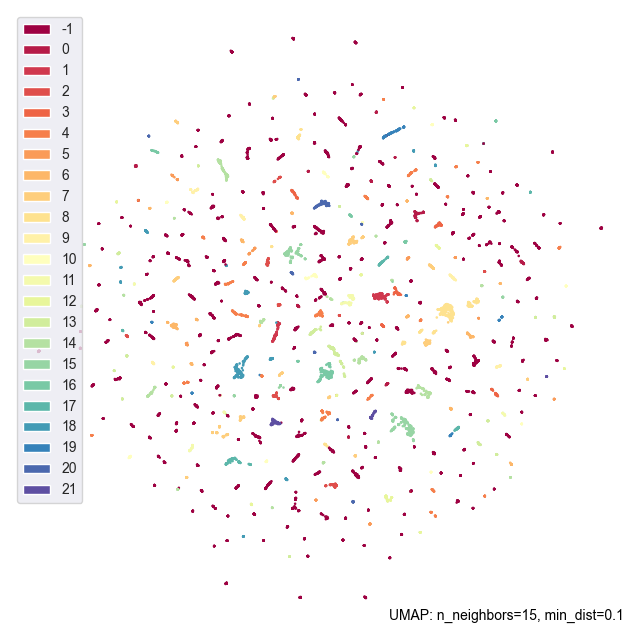

In [99]:
umap_model_visualization = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2).fit(df_anomaly_one_hot_scaled)
umap.plot.points(umap_model_visualization, labels=clusters)

In [100]:
from sklearn.metrics import silhouette_score
silhouette_score(df_anomaly_one_hot_scaled, clusters)

-0.1432458911516732